In [2]:
# op stats
import os
from importlib import reload
import operation_statistics as op_stats

reload(op_stats)
os.chdir('//share.ipp-hgw.mpg.de/documents/pih/Documents/git/QSB_Bolometry/libprad/')

# stat = op_stats.op_statistics(year='2018', vers='V2')

In [3]:
reload(op_stats)
data = op_stats.get_op_statistics(file='op_2018_statistics_v2.json')

In [4]:
import numpy as np
N = len(data.keys())

combined = {}
for i, program in enumerate(data):

    if i == 0:
        for j, key in enumerate(data[program].keys()):
            combined[key] = np.zeros((N, 128))
    for j, key in enumerate(data[program].keys()):
        combined[key][i, :] = data[program][key]

In [5]:
import matplotlib.pyplot as p
import dat_lists as lists

camera_info = lists.geom_dat_to_json()
filtered = {}

cs = ['k', 'r', 'b']
for c, cam in enumerate(['HBCm', 'VBC', 'VBCr', 'VBCl']):
    channels = camera_info['channels']['eChannels'][cam]
    ch0, ch1 = min(channels), max(channels)

    for k, key in enumerate(combined.keys()):
        if c == 0:
            filtered[key] = {}
        filtered[key][cam] = [None] * len(channels)

        for j, ch in enumerate(channels): 
            filtered[key][cam][j] = combined[key][:, ch][
                combined[key][:, ch] > 0.0]

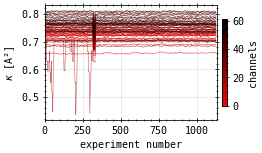

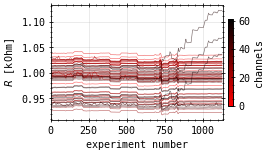

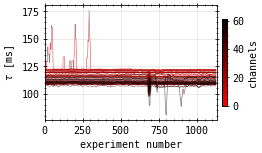

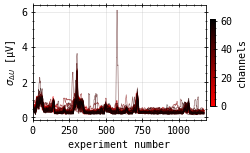

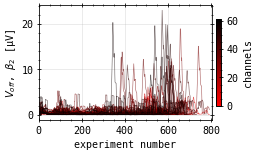

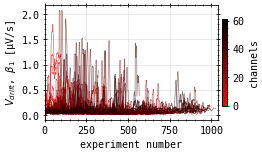

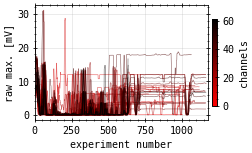

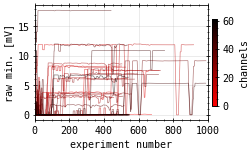

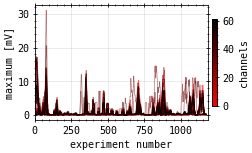

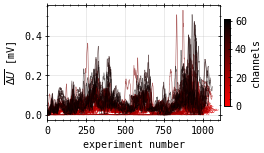

In [20]:
import matplotlib as mpl
from matplotlib import cm
cmap_base = ['black', 'black', 'black']

# savelocation
loc = '//share.ipp-hgw.mpg.de/documents/pih/Documents/git/LaTeX/THESIS/content/figures/chapter1/'

ylabs = [
    '$\kappa$ [A²]', '$R$ [kOhm]', '$\\tau$ [ms]',
    '$\sigma_{\Delta U}$ [µV]' , '$V_{off}$, $\\beta_{2}$ [µV]', '$V_{drift}$, $\\beta_{1}$ [µV/s]',
    'raw max. [mV]', 'raw min. [mV]', 'maximum [mV]', '$\overline{\Delta U}$ [mV]']
yF = [1.e3, 1.e-3, 1.e3, 1.e6, 1.e6, 1.e6, 1.e3, 1.e3, 1.e3, 1.e3, 1.e3]
ylims = np.array([
    [0.65, 0.82], [0.9, 1.05], [100., 125.], [.0, .8],
    [.0, 3.], [.0, .5], [.0, 20.], [.0, 20.], [.0, 10.], [.0, .2]])
cams = ['HBCm', 'VBC']  # 'VBCr', 'VBCl']
percentile = 0.99

broken = camera_info['channels']['droplist']

for k, key in enumerate([
        'Kappam', 'Rohm', 'Taum',
        'std_dev', 'abs_offs', 'slope',
        'raw_max', 'raw_min', 'adj_max', 'adj_median']):
    fig, ax, cbar_ax = p.figure(), [], []
    fig.set_size_inches(3., 4.)

    ax.append(fig.add_axes([0.1, 1.0, 0.8, 0.4]))
    cbar_ax.append(fig.add_axes([0.92, 1.05, 0.025, 0.3]))

    if False:
        ax[0].set_title(
            ylabs[k].split()[0] + ' -- ' +
            format(percentile * 100., '.1f') +
            'th percentile')

    CH = []
    for c, cam in enumerate(cams):        
        channels = camera_info['channels']['eChannels'][cam]
        for j, ch in enumerate(channels):
            if ch in broken:
                continue
            CH.append(ch)

    norm = mpl.colors.Normalize(
        vmin=0, vmax=len(CH))
    c_m = mpl.colors.LinearSegmentedColormap.from_list(
        'mycolors', ['red', cmap_base[c]])

    s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])

    N, J = 0, 0
    for c, cam in enumerate(cams):
        channels = camera_info['channels']['eChannels'][cam]
        
        for j, ch in enumerate(channels):
            if ch in broken:
                continue

            f = filtered[key][cam][j][
                filtered[key][cam][j] < np.quantile(
                    filtered[key][cam][j], percentile)]
            N = np.shape(f)[0] if np.shape(f)[0] > N else N

            if not (ylims[k, 0] < np.mean(f) * yF[k] < ylims[k, 1]):
                continue

            l, = ax[0].plot(
                np.convolve(yF[k] * f, np.ones((10,)) / 10, mode='valid'),
                lw=0.6, alpha=0.6, color=s_m.to_rgba(J))
            J += 1

        ax[0].set_ylabel(ylabs[k])
        fig.colorbar(s_m, cax=cbar_ax[0])
        cbar_ax[0].set_ylabel('channels')

    ax[0].set_xlabel('experiment number')
    ax[0].set_xlim(0, N)

    fig.savefig(
        loc + key + '_' +
        format(percentile * 100., 'g') + 'th_OP12b.pdf', dpi=169.)

In [26]:
kappa, roh, tau = np.zeros((128)), np.zeros((128)), np.zeros((128))

for c, cam in enumerate(['HBCm', 'VBCr', 'VBCl']):
    channels = camera_info['channels']['eChannels'][cam]

    for j, ch in enumerate(channels):
        kappa[ch] = np.quantile(filtered['Kappam'][cam][j], .925)
        roh[ch] = np.quantile(filtered['Rohm'][cam][j], .925)
        tau[ch] = np.quantile(filtered['Taum'][cam][j], .925)

np.savetxt(
    '../../default_kappam.dat', kappa, fmt='%.9f', encoding='utf-8')
np.savetxt(
    '../../default_rohm.dat', roh, fmt='%.9f', encoding='utf-8')
np.savetxt(
    '../../default_taum.dat', tau, fmt='%.9f', encoding='utf-8')

np.savetxt(
    '../../default_calibs.dat', np.array([kappa, roh, tau]).transpose(),
    fmt='%.8f', encoding='utf-8', delimiter='    ',
    header='# kappa [A^2]        roh [Ohm]        tau [s]')

In [7]:
ylabs = [
    '$\kappa$ [A²]', '$\Omega$ [kOhm]', '$\\tau$ [ms]',
    '$\sigma$ [µV]' , 'offset [µV]', 'drift [µV/s]',
    'raw max. [mV]', 'raw min. [mV]', 'maximum [mV]', 'median [mV]']
yF = [1.e3, 1.e-3, 1.e3, 1.e6, 1.e6, 1.e6, 1.e3, 1.e3, 1.e3, 1.e3, 1.e3]

for k, key in enumerate([
        'Kappam', 'Rohm', 'Taum',
        'std_dev', 'abs_offs', 'slope',
        'raw_max', 'raw_min', 'adj_max', 'adj_median']):
    for cam in ['HBCm', 'VBC']:
        mn = np.mean([
            np.mean(x) for x in filtered[key][cam]])
        md = np.median([
            np.median(x) for x in filtered[key][cam]])
        std = np.std([
            np.std(x) for x in filtered[key][cam]])
        print('>> ' + key + ' ' + cam + ' mean:',
              format(mn * yF[k], '.3f') + ylabs[k] + ', median:',
              format(md * yF[k], '.3f') + ylabs[k] + ', std:',
              format(std * yF[k], '.3f') + ylabs[k])

>> Kappam HBCm mean: 0.754$\kappa$ [A²], median: 0.724$\kappa$ [A²], std: 0.545$\kappa$ [A²]
>> Kappam VBC mean: 0.944$\kappa$ [A²], median: 0.766$\kappa$ [A²], std: 12.574$\kappa$ [A²]
>> Rohm HBCm mean: 1.007$\Omega$ [kOhm], median: 1.007$\Omega$ [kOhm], std: 0.006$\Omega$ [kOhm]
>> Rohm VBC mean: 0.993$\Omega$ [kOhm], median: 0.987$\Omega$ [kOhm], std: 0.011$\Omega$ [kOhm]
>> Taum HBCm mean: 120.463$\tau$ [ms], median: 119.452$\tau$ [ms], std: 8.862$\tau$ [ms]
>> Taum VBC mean: 112.269$\tau$ [ms], median: 110.573$\tau$ [ms], std: 4.930$\tau$ [ms]
>> std_dev HBCm mean: 1.379$\sigma$ [µV], median: 0.339$\sigma$ [µV], std: 37.938$\sigma$ [µV]
>> std_dev VBC mean: 1.237$\sigma$ [µV], median: 0.302$\sigma$ [µV], std: 12.586$\sigma$ [µV]
>> abs_offs HBCm mean: 8.317offset [µV], median: 0.204offset [µV], std: 31.110offset [µV]
>> abs_offs VBC mean: 8.421offset [µV], median: 0.168offset [µV], std: 42.896offset [µV]
>> slope HBCm mean: 1.339drift [µV/s], median: 0.039drift [µV/s], std: 32.45